In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def lennard_jones_potential(r, sigma: float, eps: float) -> np.ndarray:
    return 4 * eps * np.power(sigma, 12) / np.power(r, 12) - 4 * eps * np.power(sigma, 6) / np.power(r, 6)


def lennard_jones_force(r, sigma: float, eps: float) -> np.ndarray:
    return 24 * eps * np.power(sigma, 6) / np.power(r, 7) - 48 * eps * np.power(sigma, 12) / np.power(r, 13)


def get_kinetic_energy(m, v):
    return m * (v ** 2) / 2


def get_verlet_next_x(x, v, f, m, dt):
    a = f / m
    return x + v * dt + a * (dt ** 2) / 2


def get_verlet_next_f(r, rx, sigma: float, eps: float):
    return np.sum(lennard_jones_force(r, sigma, eps) * rx / r)


def get_verlet_next_u(rs, sigma: float, eps: float):
    return np.sum(lennard_jones_potential(rs, sigma, eps)) / 2


def get_verlet_next_v(v, f, f_next, m, dt):
    a, a_next = f / m, f_next / m
    return v + ((a + a_next) * dt) / 2


def get_verlet_next(p: np.ndarray, rx: np.ndarray, ry: np.ndarray, dt: float, sigma: float, eps: float):
    r = np.sqrt(np.power(rx, 2) + np.power(ry, 2))

    fx_next = get_verlet_next_f(r, rx, sigma, eps)
    fy_next = get_verlet_next_f(r, ry, sigma, eps)

    vx_next = get_verlet_next_v(p[P_VX], p[P_FX], fx_next, p[P_M], dt)
    vy_next = get_verlet_next_v(p[P_VY], p[P_FY], fy_next, p[P_M], dt)
    v_next = np.sqrt(np.power(vx_next, 2) + np.power(vy_next, 2))

    u_next = get_verlet_next_u(r, sigma, eps)
    ek_next = get_kinetic_energy(p[P_M], v_next)

    return fx_next, fy_next, vx_next, vy_next, v_next, u_next, ek_next

In [3]:
# %% Parameters
SIGMA = 1
EPS = 1.5
SIMULATION_TIME = 10

# %% Indexes
P_ID, P_M, P_X, P_Y, P_VX, P_VY, P_FX, P_FY, P_X_NEXT, P_Y_NEXT, P_VX_NEXT, P_VY_NEXT, P_FX_NEXT, P_FY_NEXT = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
R_ID, R_M, R_X, R_Y, R_VX, R_VY, R_FX, R_FY, R_U, R_EK, R_ET, R_T = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

In [4]:
def verlet_algo(particles: np.ndarray, simulation_time: float, dt: float, sigma: float, eps: float) -> np.ndarray:
    time = np.arange(0, simulation_time + dt, dt)

    result = np.zeros(shape=(particles.shape[0], time.shape[0], 12))

    for i in range(particles.shape[0]):
        result[i, :, R_ID] = np.repeat(particles[i, P_ID], result.shape[1])
        result[i, :, R_M] = np.repeat(particles[i, P_M], result.shape[1])

    result[:, 0, R_X] = particles[:, P_X]
    result[:, 0, R_Y] = particles[:, P_Y]
    result[:, 0, R_VX] = particles[:, P_VX]
    result[:, 0, R_VY] = particles[:, P_VY]
    result[:, 0, R_FX] = particles[:, P_FX]
    result[:, 0, R_FY] = particles[:, P_FY]
    result[:, 0, R_U] = 0
    result[:, 0, R_EK] = 0
    result[:, 0, R_ET] = 0
    result[:, :, R_T] = time

    # рассчитаем начальные силы и энергии
    for i in range(particles.shape[0]):
        p = particles[i]
        p_id = p[P_ID].astype(np.int64)
        neighbours = particles[particles[:, P_ID] != p[P_ID]]

        rx = neighbours[:, P_X] - p[P_X]
        ry = neighbours[:, P_Y] - p[P_Y]

        fx, fy, vx, vy, v, u, ek = get_verlet_next(p, rx, ry, dt, sigma, eps)

        particles[i, P_FX] = fx
        particles[i, P_FY] = fy

        result[p_id, 0, R_FX] = fx
        result[p_id, 0, R_FY] = fy
        result[p_id, 0, R_U] = u
        result[p_id, 0, R_EK] = ek
        result[p_id, 0, R_ET] = ek + u

    for curr in range(len(time) - 1):
        next = curr + 1

        # для всех посчитаем следующую координату
        particles[:, P_X_NEXT] = get_verlet_next_x(particles[:, P_X], particles[:, P_VX], particles[:, P_FX],
                                                   particles[:, P_M], dt)
        particles[:, P_Y_NEXT] = get_verlet_next_x(particles[:, P_Y], particles[:, P_VY], particles[:, P_FY],
                                                   particles[:, P_M], dt)

        for i in range(particles.shape[0]):
            p = particles[i]
            p_id = p[P_ID].astype(np.int64)
            neighbours = particles[particles[:, P_ID] != p[P_ID]]

            rx = neighbours[:, P_X_NEXT] - p[P_X_NEXT]
            ry = neighbours[:, P_Y_NEXT] - p[P_Y_NEXT]

            fx_next, fy_next, vx_next, vy_next, v_next, u_next, ek_next = get_verlet_next(p, rx, ry, dt, sigma, eps)

            p[P_VX_NEXT] = vx_next
            p[P_VY_NEXT] = vy_next
            p[P_FX_NEXT] = fx_next
            p[P_FY_NEXT] = fy_next

            result[p_id, next, R_X] = p[P_X_NEXT]
            result[p_id, next, R_Y] = p[P_Y_NEXT]
            result[p_id, next, R_VX] = vx_next
            result[p_id, next, R_VY] = vy_next
            result[p_id, next, R_FX] = fx_next
            result[p_id, next, R_FY] = fy_next
            result[p_id, next, R_U] = u_next
            result[p_id, next, R_EK] = ek_next
            result[p_id, next, R_ET] = ek_next + u_next

        # применим изменения параметров к частицам
        particles[:, P_X] = particles[:, P_X_NEXT]
        particles[:, P_Y] = particles[:, P_Y_NEXT]
        particles[:, P_VX] = particles[:, P_VX_NEXT]
        particles[:, P_VY] = particles[:, P_VY_NEXT]
        particles[:, P_FX] = particles[:, P_FX_NEXT]
        particles[:, P_FY] = particles[:, P_FY_NEXT]

    return result

# 1D variant (X axis)

In [5]:
delta_t = 0.01

# (ẋ == x_next)
particles = np.array([
    #id,m, x,  y, vx,vy,fx,fy,ẋ, ẏ, vẋ,vẏ,fẋ,fẏ
    [0, 2, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 3, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)

data = verlet_algo(particles, SIMULATION_TIME, delta_t, SIGMA, EPS)

time = data[0, :, R_T]

x1_verlet = data[0, :, R_X]
x2_verlet = data[1, :, R_X]
x3_verlet = data[2, :, R_X]
y1_verlet = data[0, :, R_Y]
y2_verlet = data[1, :, R_Y]
y3_verlet = data[2, :, R_Y]

vx1_verlet = data[0, :, R_VX]
vx2_verlet = data[1, :, R_VX]
vx3_verlet = data[2, :, R_VX]
vy1_verlet = data[0, :, R_VY]
vy2_verlet = data[1, :, R_VY]
vy3_verlet = data[2, :, R_VY]

total_energy_verlet = np.sum(data[:, :, R_ET], axis=0)
potential_verlet = np.sum(data[:, :, R_U], axis=0)
energy_kinetic1_verlet = data[0, :, R_EK]
energy_kinetic2_verlet = data[1, :, R_EK]
energy_kinetic3_verlet = data[2, :, R_EK]

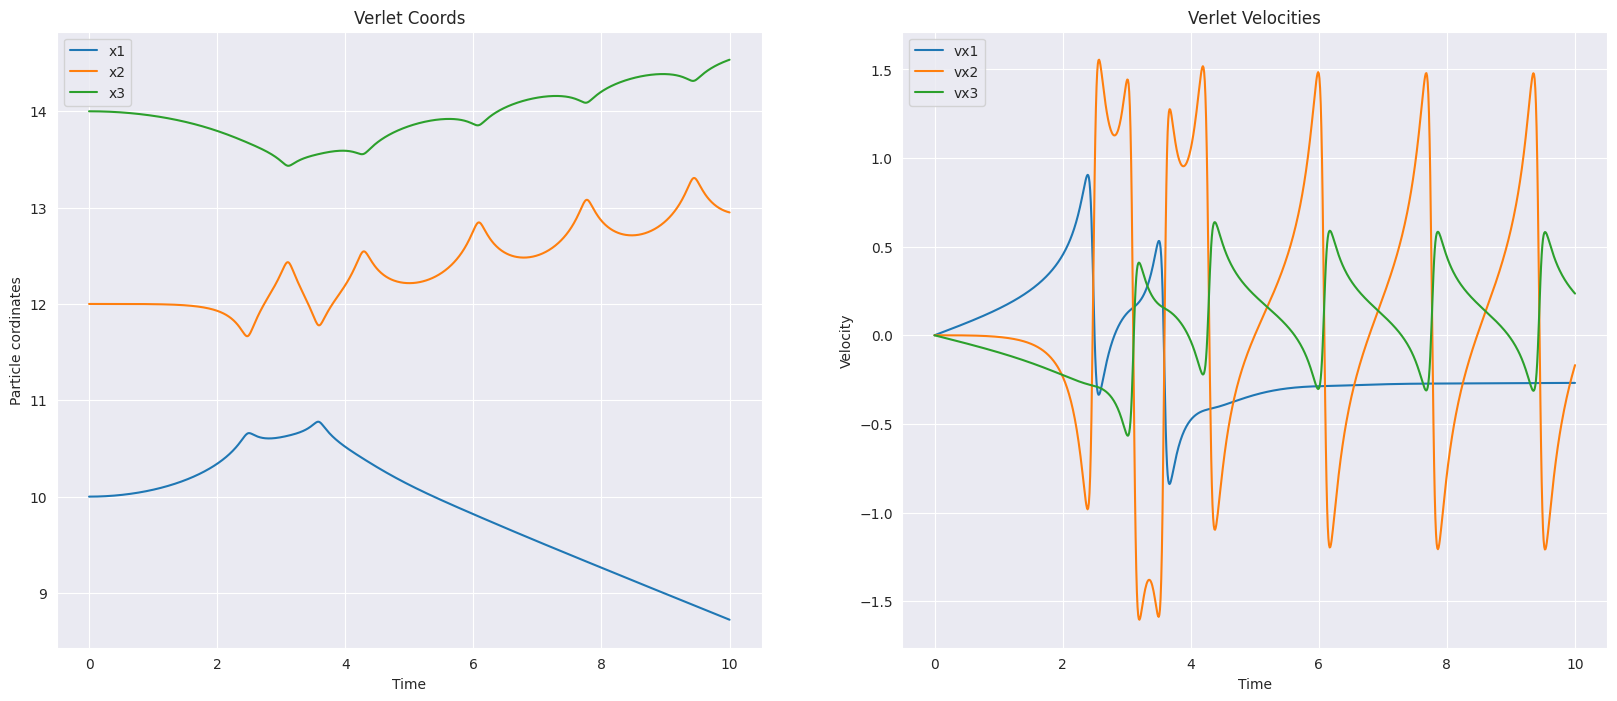

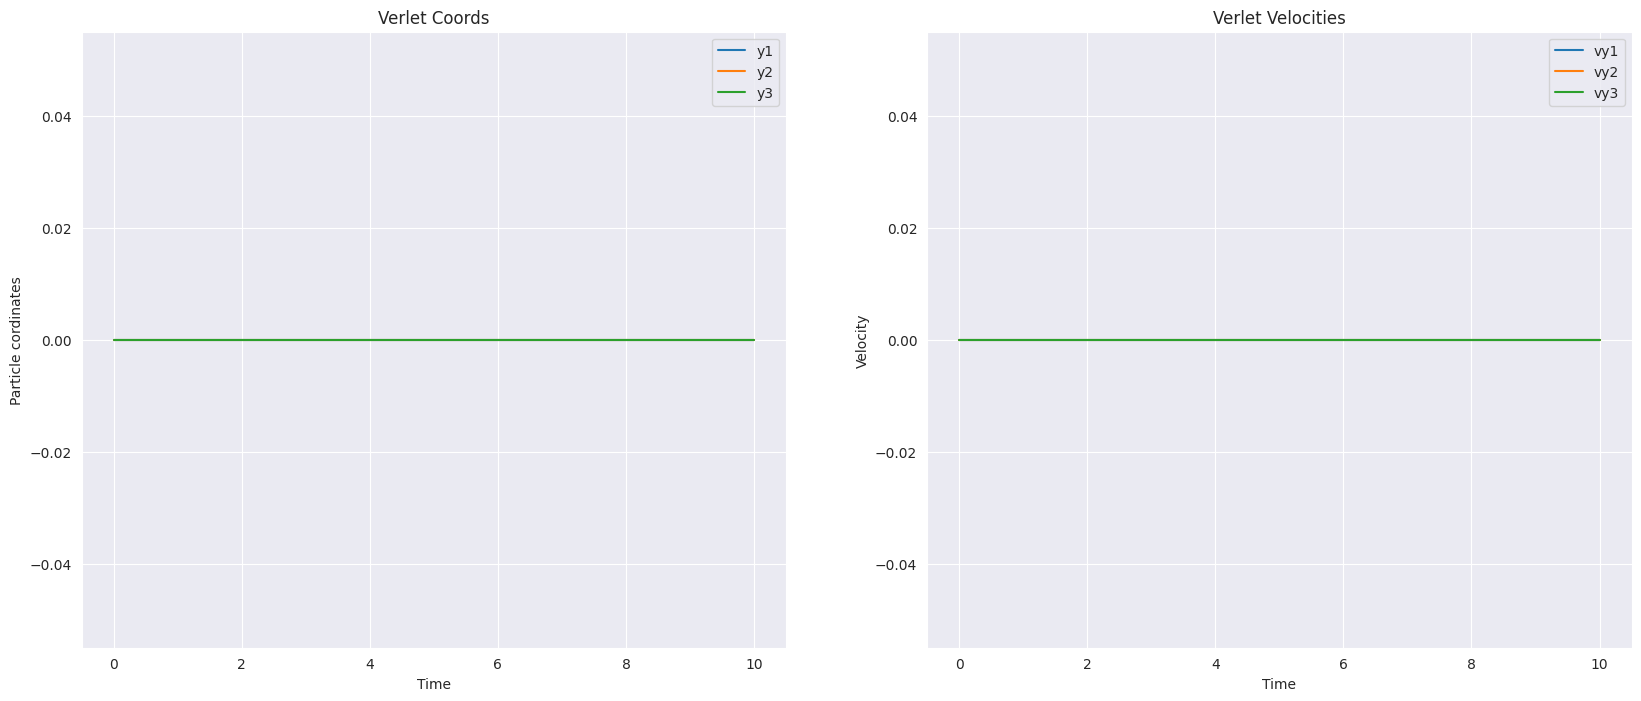

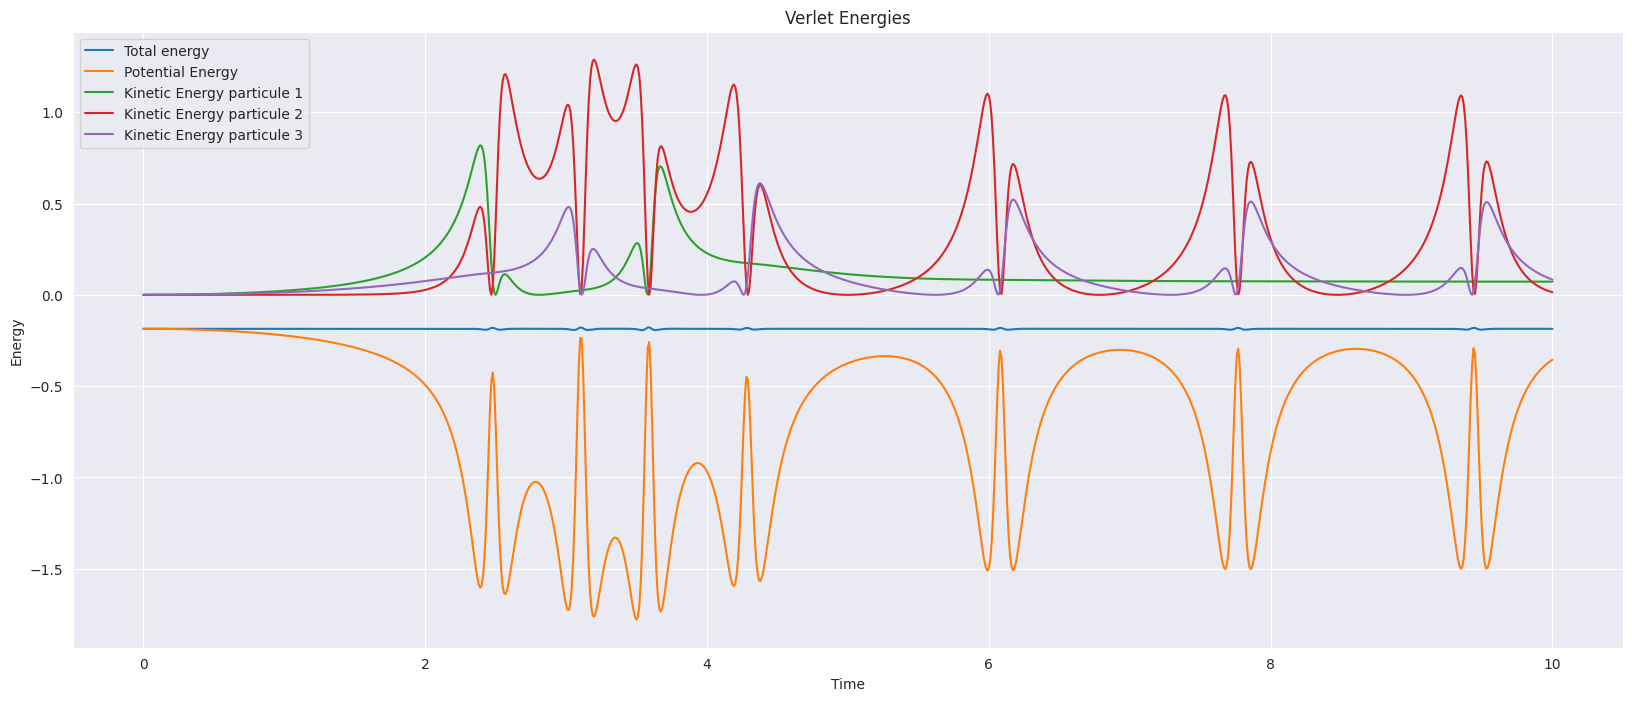

In [6]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=x1_verlet,
    ax=axes[0],
    label='x1',
)
sns.lineplot(
    x=time,
    y=x2_verlet,
    ax=axes[0],
    label='x2',
)
sns.lineplot(
    x=time,
    y=x3_verlet,
    ax=axes[0],
    label='x3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vx1_verlet,
    ax=axes[1],
    label='vx1',
)
sns.lineplot(
    x=time,
    y=vx2_verlet,
    ax=axes[1],
    label='vx2',
)
sns.lineplot(
    x=time,
    y=vx3_verlet,
    ax=axes[1],
    label='vx3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=y1_verlet,
    ax=axes[0],
    label='y1',
)
sns.lineplot(
    x=time,
    y=y2_verlet,
    ax=axes[0],
    label='y2',
)
sns.lineplot(
    x=time,
    y=y3_verlet,
    ax=axes[0],
    label='y3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vy1_verlet,
    ax=axes[1],
    label='vy1',
)
sns.lineplot(
    x=time,
    y=vy2_verlet,
    ax=axes[1],
    label='vy2',
)
sns.lineplot(
    x=time,
    y=vy3_verlet,
    ax=axes[1],
    label='vy3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=total_energy_verlet,
    ax=ax,
    label='Total energy',
)
sns.lineplot(
    x=time,
    y=potential_verlet,
    ax=ax,
    label='Potential Energy',
)
sns.lineplot(
    x=time,
    y=energy_kinetic1_verlet,
    ax=ax,
    label='Kinetic Energy particule 1',
)
sns.lineplot(
    x=time,
    y=energy_kinetic2_verlet,
    ax=ax,
    label='Kinetic Energy particule 2',
)
sns.lineplot(
    x=time,
    y=energy_kinetic3_verlet,
    ax=ax,
    label='Kinetic Energy particule 3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Energy')
plot.set_title("Verlet Energies");

# 1D variant (Y axis)

In [7]:
delta_t = 0.01

# (ẋ == x_next)
particles = np.array([
    #id,m, x, y,  vx,vy,fx,fy,ẋ, ẏ, vẋ,vẏ,fẋ,fẏ
    [0, 2, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 3, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)

data = verlet_algo(particles, SIMULATION_TIME, delta_t, SIGMA, EPS)

time = data[0, :, R_T]

x1_verlet = data[0, :, R_X]
x2_verlet = data[1, :, R_X]
x3_verlet = data[2, :, R_X]
y1_verlet = data[0, :, R_Y]
y2_verlet = data[1, :, R_Y]
y3_verlet = data[2, :, R_Y]

vx1_verlet = data[0, :, R_VX]
vx2_verlet = data[1, :, R_VX]
vx3_verlet = data[2, :, R_VX]
vy1_verlet = data[0, :, R_VY]
vy2_verlet = data[1, :, R_VY]
vy3_verlet = data[2, :, R_VY]

total_energy_verlet = np.sum(data[:, :, R_ET], axis=0)
potential_verlet = np.sum(data[:, :, R_U], axis=0)
energy_kinetic1_verlet = data[0, :, R_EK]
energy_kinetic2_verlet = data[1, :, R_EK]
energy_kinetic3_verlet = data[2, :, R_EK]

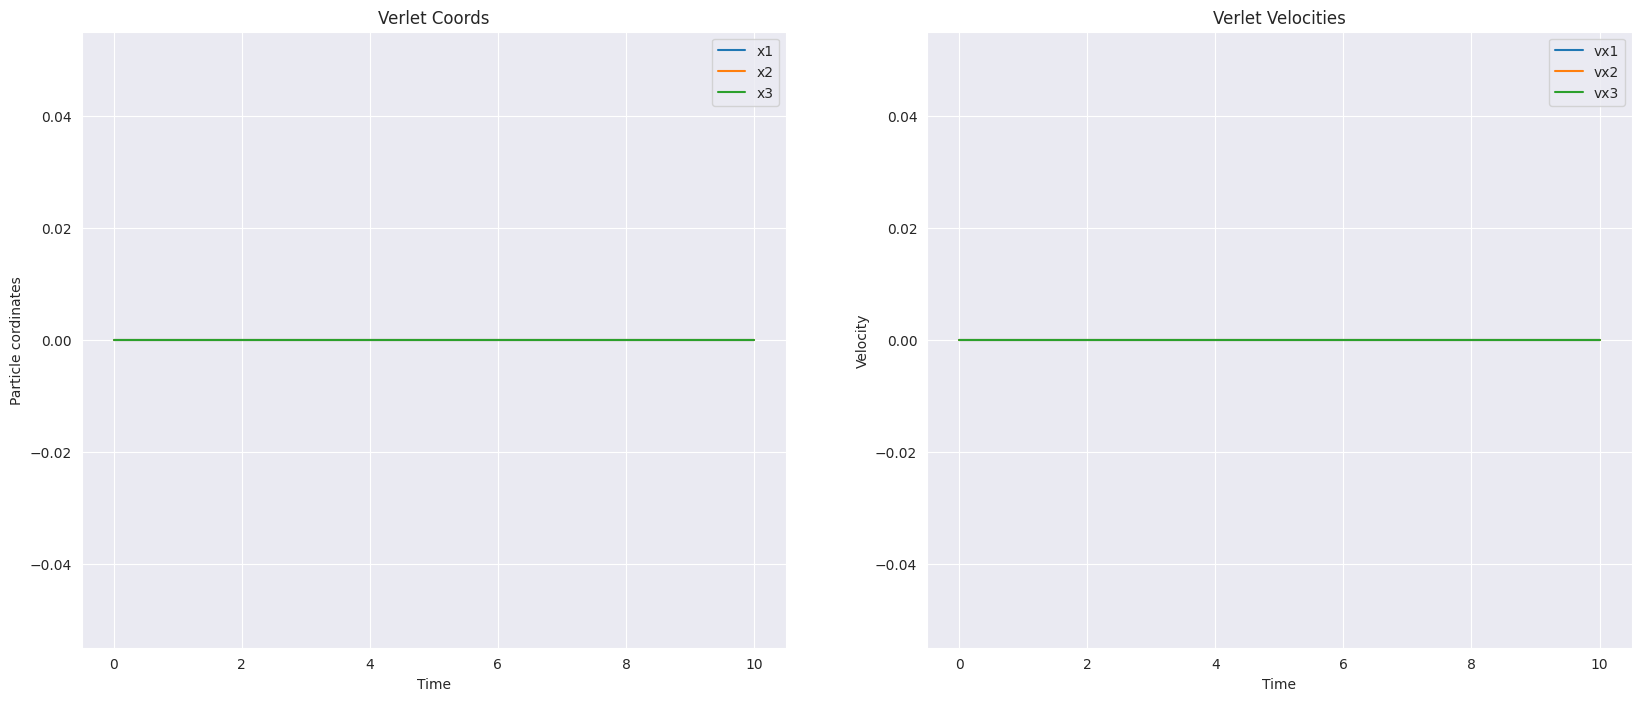

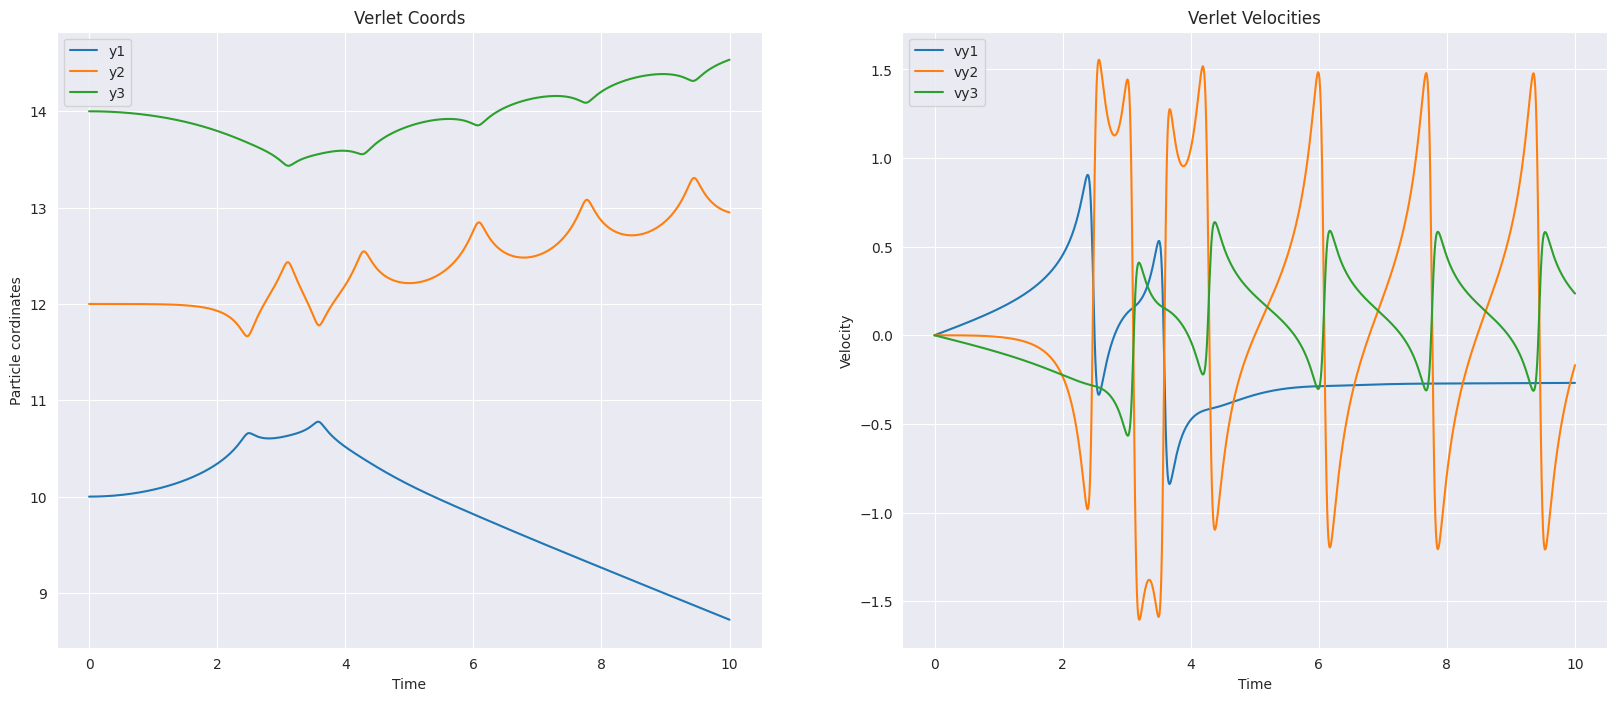

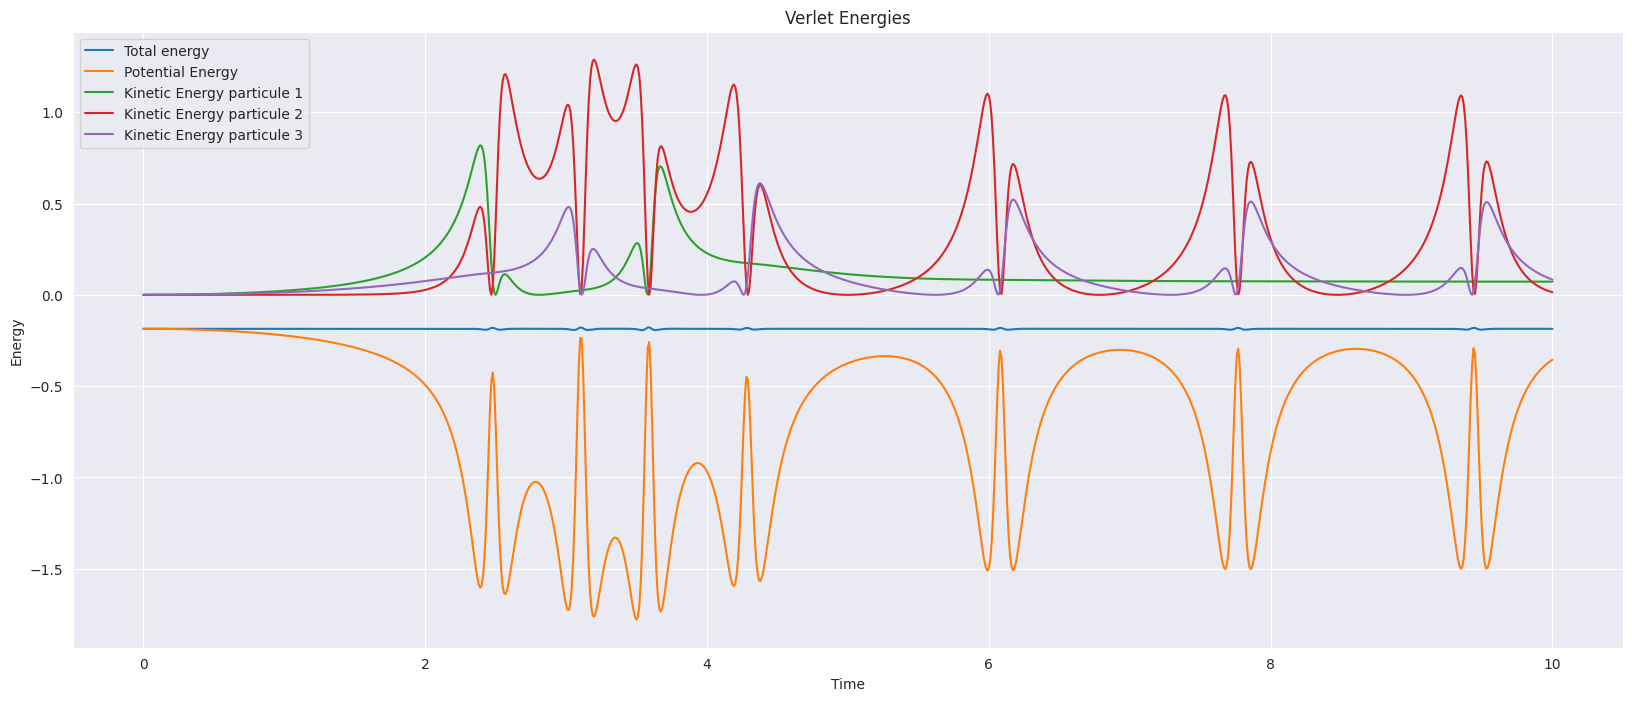

In [8]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=x1_verlet,
    ax=axes[0],
    label='x1',
)
sns.lineplot(
    x=time,
    y=x2_verlet,
    ax=axes[0],
    label='x2',
)
sns.lineplot(
    x=time,
    y=x3_verlet,
    ax=axes[0],
    label='x3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vx1_verlet,
    ax=axes[1],
    label='vx1',
)
sns.lineplot(
    x=time,
    y=vx2_verlet,
    ax=axes[1],
    label='vx2',
)
sns.lineplot(
    x=time,
    y=vx3_verlet,
    ax=axes[1],
    label='vx3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=y1_verlet,
    ax=axes[0],
    label='y1',
)
sns.lineplot(
    x=time,
    y=y2_verlet,
    ax=axes[0],
    label='y2',
)
sns.lineplot(
    x=time,
    y=y3_verlet,
    ax=axes[0],
    label='y3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vy1_verlet,
    ax=axes[1],
    label='vy1',
)
sns.lineplot(
    x=time,
    y=vy2_verlet,
    ax=axes[1],
    label='vy2',
)
sns.lineplot(
    x=time,
    y=vy3_verlet,
    ax=axes[1],
    label='vy3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=total_energy_verlet,
    ax=ax,
    label='Total energy',
)
sns.lineplot(
    x=time,
    y=potential_verlet,
    ax=ax,
    label='Potential Energy',
)
sns.lineplot(
    x=time,
    y=energy_kinetic1_verlet,
    ax=ax,
    label='Kinetic Energy particule 1',
)
sns.lineplot(
    x=time,
    y=energy_kinetic2_verlet,
    ax=ax,
    label='Kinetic Energy particule 2',
)
sns.lineplot(
    x=time,
    y=energy_kinetic3_verlet,
    ax=ax,
    label='Kinetic Energy particule 3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Energy')
plot.set_title("Verlet Energies");

# 2D variant (Y axis)

In [70]:
# (ẋ == x_next)
particles = np.array([
    #id,m, x,  y,  vx,vy,fx,fy,ẋ, ẏ, vẋ,vẏ,fẋ,fẏ
    [0, 2, 11, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 10, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 3, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)

data = verlet_algo(particles, SIMULATION_TIME, dt=0.002, sigma=SIGMA, eps=EPS)

time = data[0, :, R_T]

x1_verlet = data[0, :, R_X]
x2_verlet = data[1, :, R_X]
x3_verlet = data[2, :, R_X]
y1_verlet = data[0, :, R_Y]
y2_verlet = data[1, :, R_Y]
y3_verlet = data[2, :, R_Y]

vx1_verlet = data[0, :, R_VX]
vx2_verlet = data[1, :, R_VX]
vx3_verlet = data[2, :, R_VX]
vy1_verlet = data[0, :, R_VY]
vy2_verlet = data[1, :, R_VY]
vy3_verlet = data[2, :, R_VY]

total_energy_verlet = np.sum(data[:, :, R_ET], axis=0)
potential_verlet = np.sum(data[:, :, R_U], axis=0)
energy_kinetic1_verlet = data[0, :, R_EK]
energy_kinetic2_verlet = data[1, :, R_EK]
energy_kinetic3_verlet = data[2, :, R_EK]

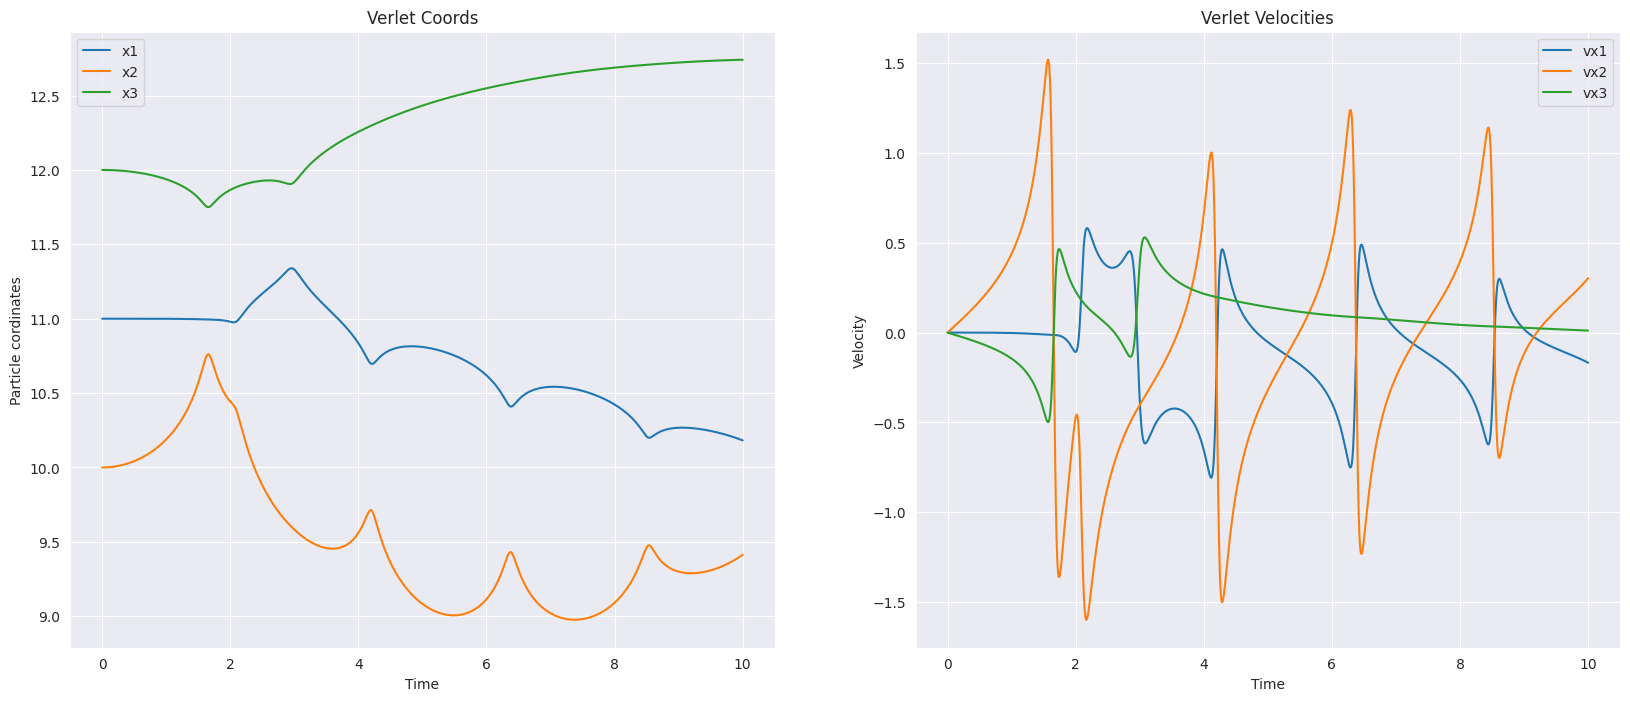

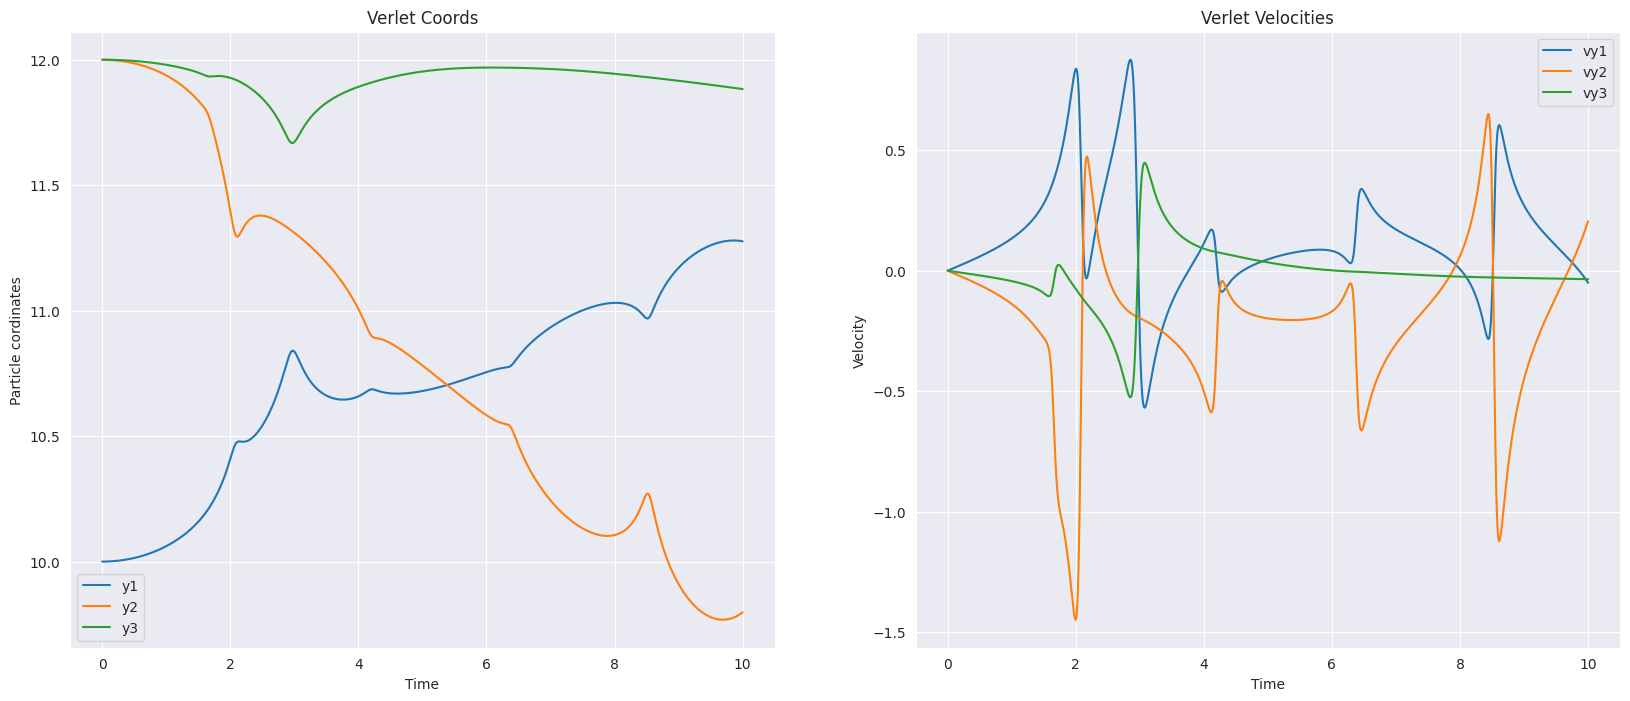

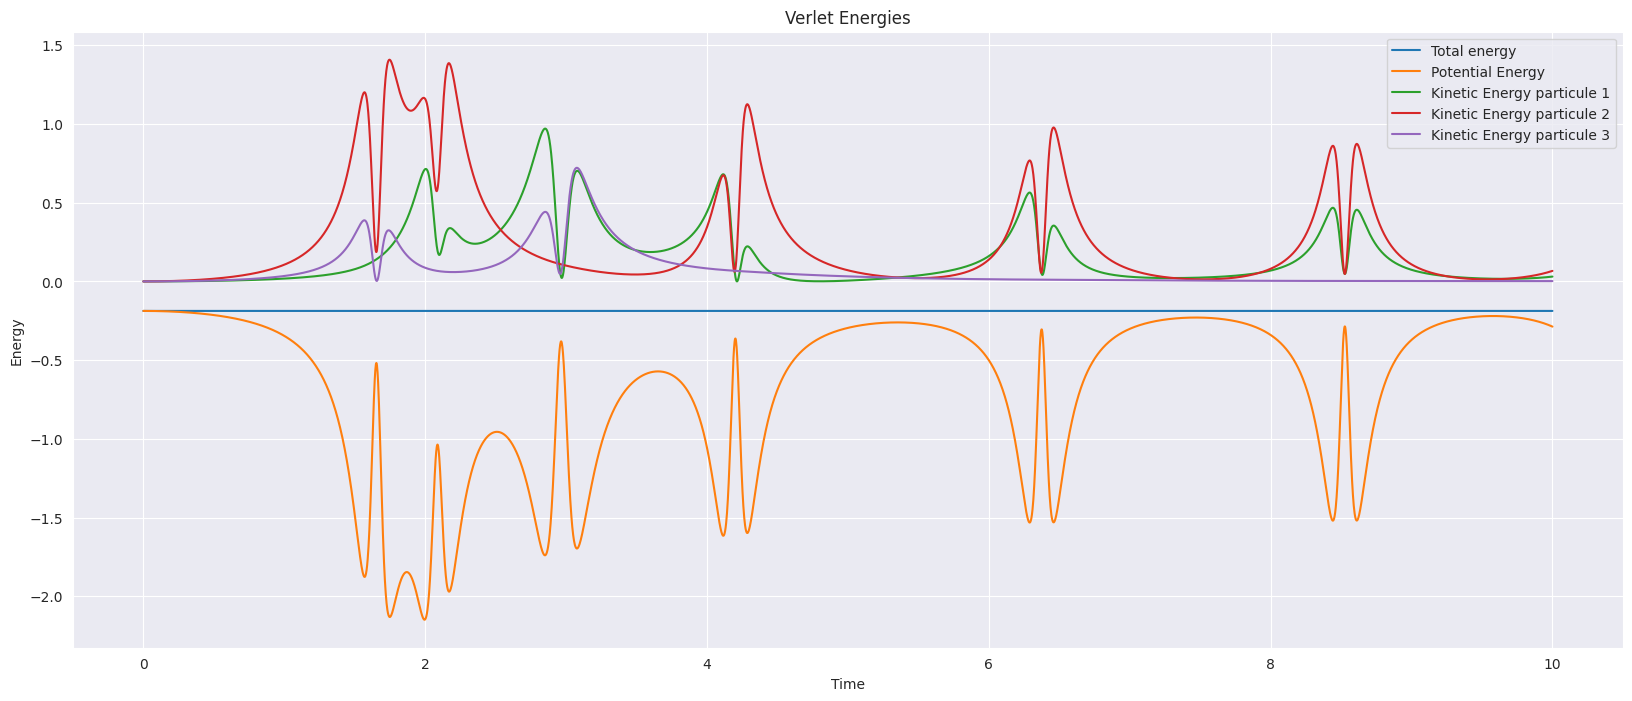

In [71]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=x1_verlet,
    ax=axes[0],
    label='x1',
)
sns.lineplot(
    x=time,
    y=x2_verlet,
    ax=axes[0],
    label='x2',
)
sns.lineplot(
    x=time,
    y=x3_verlet,
    ax=axes[0],
    label='x3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vx1_verlet,
    ax=axes[1],
    label='vx1',
)
sns.lineplot(
    x=time,
    y=vx2_verlet,
    ax=axes[1],
    label='vx2',
)
sns.lineplot(
    x=time,
    y=vx3_verlet,
    ax=axes[1],
    label='vx3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=y1_verlet,
    ax=axes[0],
    label='y1',
)
sns.lineplot(
    x=time,
    y=y2_verlet,
    ax=axes[0],
    label='y2',
)
sns.lineplot(
    x=time,
    y=y3_verlet,
    ax=axes[0],
    label='y3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vy1_verlet,
    ax=axes[1],
    label='vy1',
)
sns.lineplot(
    x=time,
    y=vy2_verlet,
    ax=axes[1],
    label='vy2',
)
sns.lineplot(
    x=time,
    y=vy3_verlet,
    ax=axes[1],
    label='vy3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=total_energy_verlet,
    ax=ax,
    label='Total energy',
)
sns.lineplot(
    x=time,
    y=potential_verlet,
    ax=ax,
    label='Potential Energy',
)
sns.lineplot(
    x=time,
    y=energy_kinetic1_verlet,
    ax=ax,
    label='Kinetic Energy particule 1',
)
sns.lineplot(
    x=time,
    y=energy_kinetic2_verlet,
    ax=ax,
    label='Kinetic Energy particule 2',
)
sns.lineplot(
    x=time,
    y=energy_kinetic3_verlet,
    ax=ax,
    label='Kinetic Energy particule 3',
)
plot.set_xlabel('Time')
plot.set_ylabel('Energy')
plot.set_title("Verlet Energies");

In [72]:
import plotly.express as px

plot_data = np.array([x[::200] for x in data])
plot_data = plot_data.reshape((-1, data.shape[2]))

px.scatter(
    plot_data, 
    x=R_X, 
    y=R_Y, 
    animation_frame=R_T, 
    animation_group=R_ID,
    size=R_M,
    range_x=[8, 13], 
    range_y=[8, 13],
    width=1300,
    height=1300,
)

# 2D variant (symmetric)

In [62]:
# (ẋ == x_next)
particles = np.array([
    #id,m, x,  y,  vx,vy,fx,fy,ẋ, ẏ, vẋ,vẏ,fẋ,fẏ
    [0, 2, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 1, 11, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [3, 2, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)

data = verlet_algo(particles, SIMULATION_TIME, dt=0.002, sigma=0.5, eps=0.5)

time = data[0, :, R_T]

x1_verlet = data[0, :, R_X]
x2_verlet = data[1, :, R_X]
x3_verlet = data[2, :, R_X]
x4_verlet = data[3, :, R_X]
y1_verlet = data[0, :, R_Y]
y2_verlet = data[1, :, R_Y]
y3_verlet = data[2, :, R_Y]
y4_verlet = data[3, :, R_Y]

vx1_verlet = data[0, :, R_VX]
vx2_verlet = data[1, :, R_VX]
vx3_verlet = data[2, :, R_VX]
vx4_verlet = data[3, :, R_VX]
vy1_verlet = data[0, :, R_VY]
vy2_verlet = data[1, :, R_VY]
vy3_verlet = data[2, :, R_VY]
vy4_verlet = data[3, :, R_VY]

total_energy_verlet = np.sum(data[:, :, R_ET], axis=0)
potential_verlet = np.sum(data[:, :, R_U], axis=0)
energy_kinetic1_verlet = data[0, :, R_EK]
energy_kinetic2_verlet = data[1, :, R_EK]
energy_kinetic3_verlet = data[2, :, R_EK]
energy_kinetic4_verlet = data[3, :, R_EK]

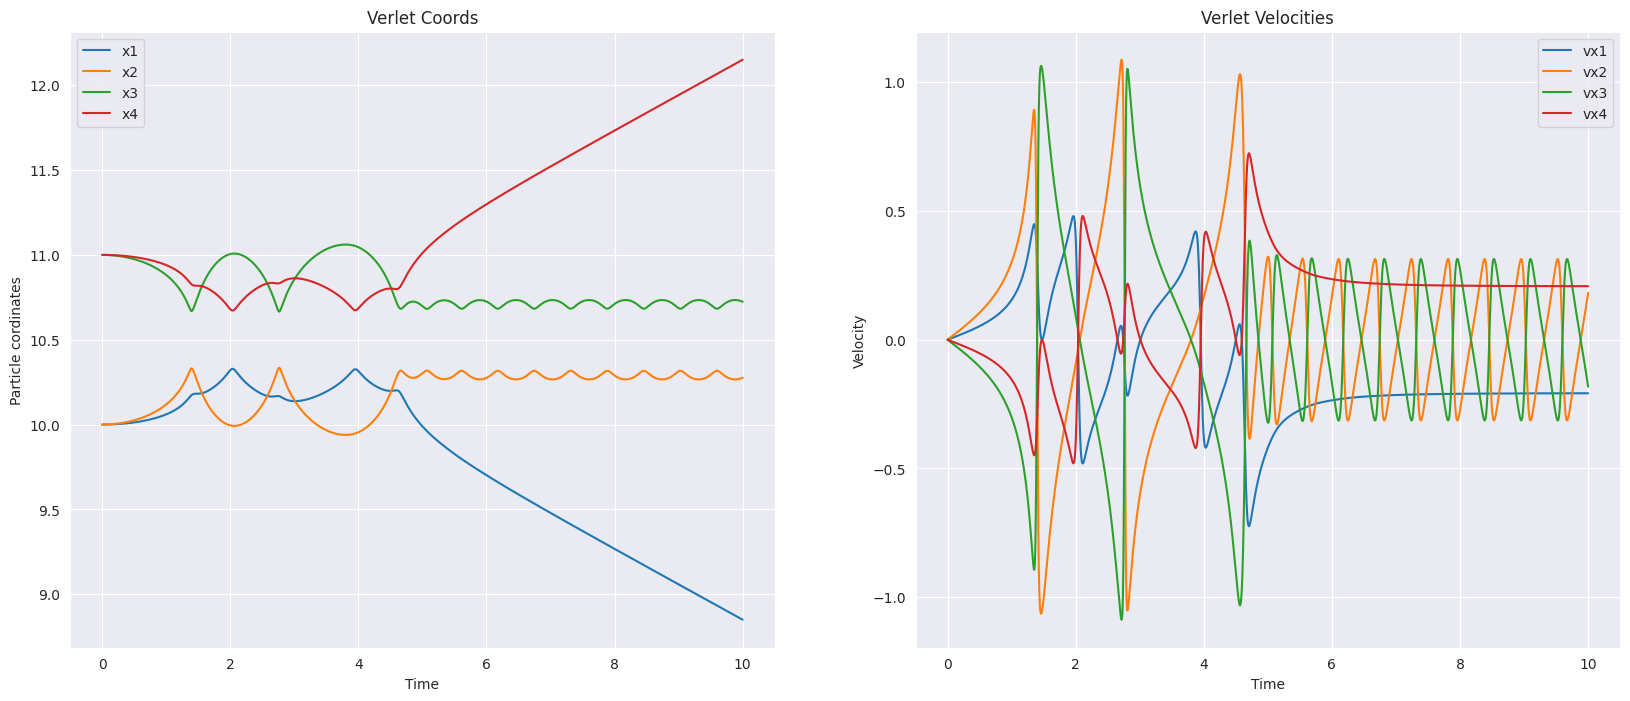

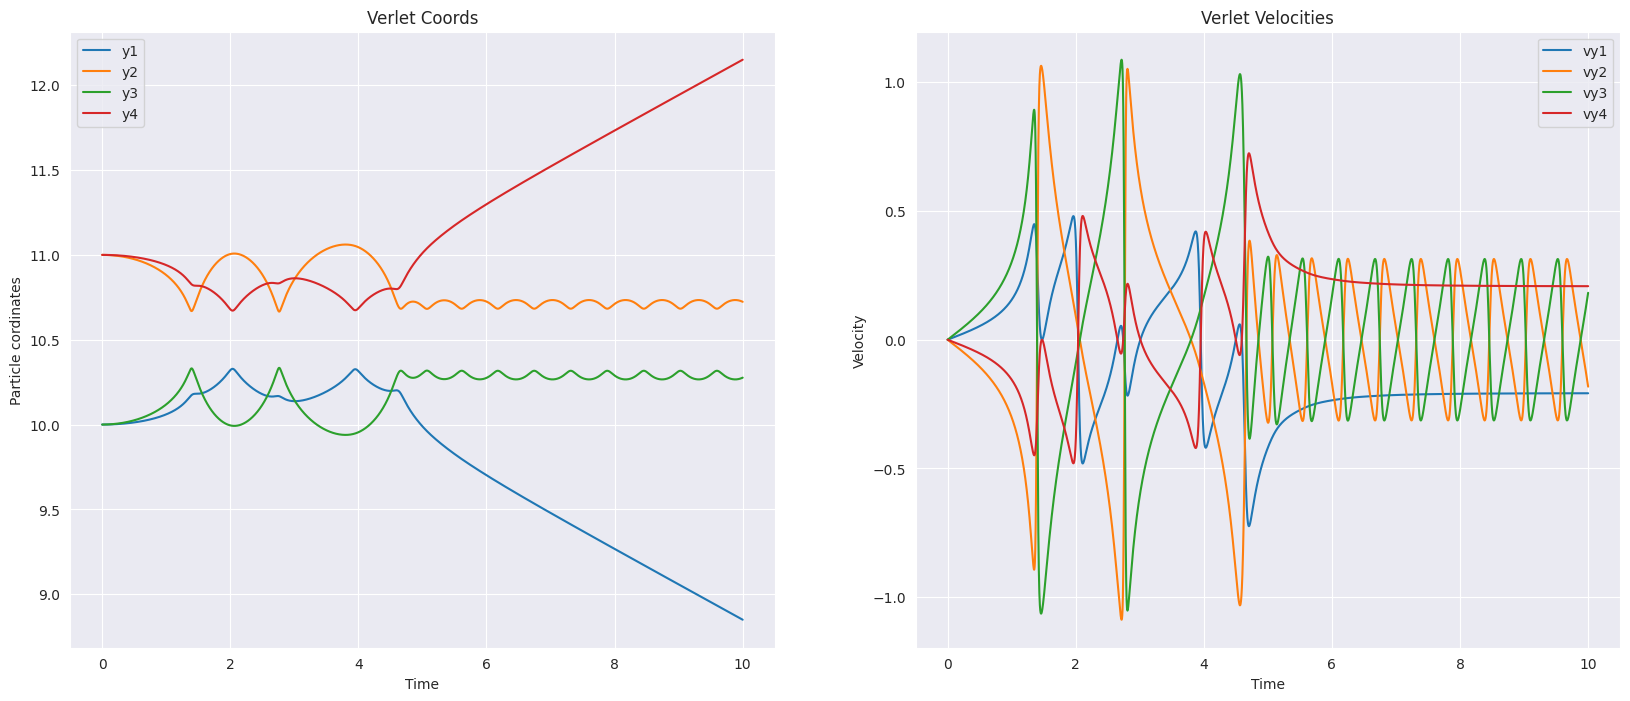

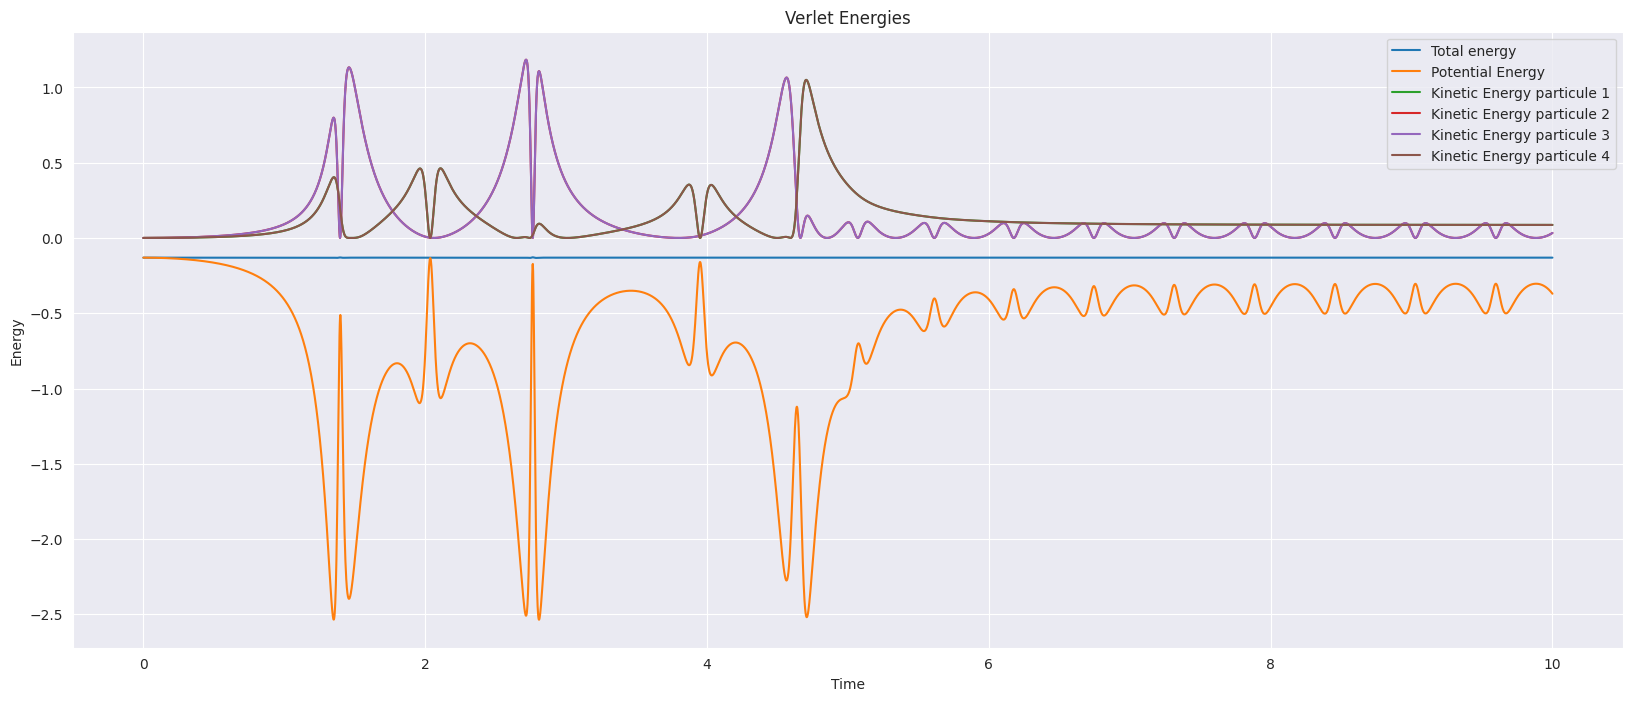

In [64]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=x1_verlet,
    ax=axes[0],
    label='x1',
)
sns.lineplot(
    x=time,
    y=x2_verlet,
    ax=axes[0],
    label='x2',
)
sns.lineplot(
    x=time,
    y=x3_verlet,
    ax=axes[0],
    label='x3',
)
sns.lineplot(
    x=time,
    y=x4_verlet,
    ax=axes[0],
    label='x4',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vx1_verlet,
    ax=axes[1],
    label='vx1',
)
sns.lineplot(
    x=time,
    y=vx2_verlet,
    ax=axes[1],
    label='vx2',
)
sns.lineplot(
    x=time,
    y=vx3_verlet,
    ax=axes[1],
    label='vx3',
)
sns.lineplot(
    x=time,
    y=vx4_verlet,
    ax=axes[1],
    label='vx4',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=y1_verlet,
    ax=axes[0],
    label='y1',
)
sns.lineplot(
    x=time,
    y=y2_verlet,
    ax=axes[0],
    label='y2',
)
sns.lineplot(
    x=time,
    y=y3_verlet,
    ax=axes[0],
    label='y3',
)
sns.lineplot(
    x=time,
    y=y4_verlet,
    ax=axes[0],
    label='y4',
)
plot.set_xlabel('Time')
plot.set_ylabel('Particle cordinates')
plot.set_title("Verlet Coords")

plot = sns.lineplot(
    x=time,
    y=vy1_verlet,
    ax=axes[1],
    label='vy1',
)
sns.lineplot(
    x=time,
    y=vy2_verlet,
    ax=axes[1],
    label='vy2',
)
sns.lineplot(
    x=time,
    y=vy3_verlet,
    ax=axes[1],
    label='vy3',
)
sns.lineplot(
    x=time,
    y=vy4_verlet,
    ax=axes[1],
    label='vy4',
)
plot.set_xlabel('Time')
plot.set_ylabel('Velocity')
plot.set_title("Verlet Velocities")

_, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 8))

plot = sns.lineplot(
    x=time,
    y=total_energy_verlet,
    ax=ax,
    label='Total energy',
)
sns.lineplot(
    x=time,
    y=potential_verlet,
    ax=ax,
    label='Potential Energy',
)
sns.lineplot(
    x=time,
    y=energy_kinetic1_verlet,
    ax=ax,
    label='Kinetic Energy particule 1',
)
sns.lineplot(
    x=time,
    y=energy_kinetic2_verlet,
    ax=ax,
    label='Kinetic Energy particule 2',
)
sns.lineplot(
    x=time,
    y=energy_kinetic3_verlet,
    ax=ax,
    label='Kinetic Energy particule 3',
)
sns.lineplot(
    x=time,
    y=energy_kinetic4_verlet,
    ax=ax,
    label='Kinetic Energy particule 4',
)
plot.set_xlabel('Time')
plot.set_ylabel('Energy')
plot.set_title("Verlet Energies");

In [69]:
import plotly.express as px

plot_data = np.array([x[::200] for x in data])
plot_data = plot_data.reshape((-1, data.shape[2]))

px.scatter(
    plot_data, 
    x=R_X, 
    y=R_Y, 
    animation_frame=R_T, 
    animation_group=R_ID,
    size=R_M,
    range_x=[8, 13], 
    range_y=[8, 13],
    width=1300,
    height=1300,
)